In [20]:
import numpy as np
import pyaudio
import time
from scipy.signal import find_peaks

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
THRESHOLD = 10000  # Adjust based on testing
MIN_SILENCE_TIME = 0.1  # Time below threshold to consider silence
DOUBLE_CLAP_MAX_WAIT = 1

def detect_clap():
    p = pyaudio.PyAudio()
    
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=CHUNK
    )
    
    print("Listening for claps... (Press Ctrl+C to stop)")
    
    last_clap_time = 0
    is_silent = True
    
    try:
        while True:
            data = np.frombuffer(stream.read(CHUNK), dtype=np.int16)
            max_amplitude = np.max(np.abs(data))
            current_time = time.time()
            
            # Detect rapid onset with fast decay (characteristic of claps)
            if max_amplitude > THRESHOLD:
                # Check for silence before this sound (claps have sudden onset)
                # if is_silent and (current_time - last_clap_time) > COOLDOWN_TIME:
                if is_silent:
                    # Look at frequency characteristics
                    fft_data = np.abs(np.fft.rfft(data))
                    # Claps have broad spectrum with energy in high frequencies
                    high_freq_energy = np.sum(fft_data[100:]) / np.sum(fft_data)
                    
                    if high_freq_energy > 0.6:  # Adjust based on testing
                        if current_time - last_clap_time < DOUBLE_CLAP_MAX_WAIT:
                            print("Double clap detected!")
                        else:
                            print("Clap detected!")
                        last_clap_time = current_time
                
                is_silent = False
            else:
                is_silent = True
    
    except KeyboardInterrupt:
        print("\nStopped listening")
    
    finally:
        stream.stop_stream()
        stream.close()
        p.terminate()

In [19]:
detect_clap()

Listening for claps... (Press Ctrl+C to stop)
Clap detected!
Clap detected!
Clap detected!
Clap detected!

Stopped listening


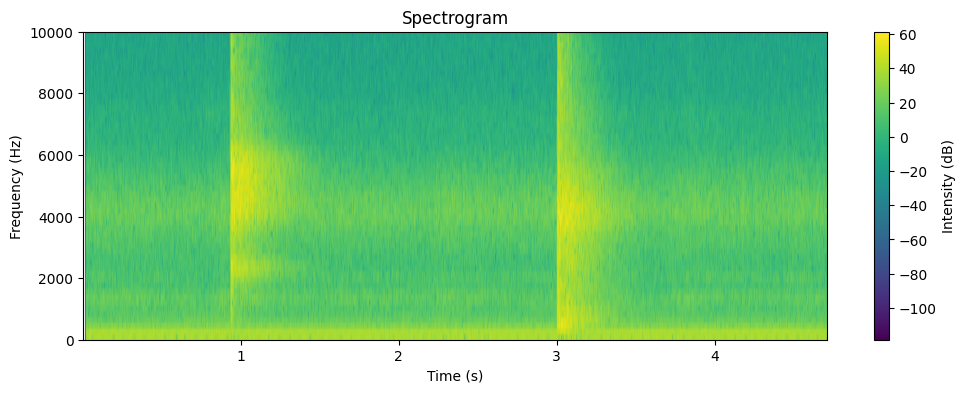

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

# Load the WAV file
sample_rate, data = wavfile.read('snap_clap.wav')

# Check if data is stereo (2 channels)
if len(data.shape) > 1 and data.shape[1] == 2:
    # Convert to mono by averaging the channels
    data_mono = np.mean(data, axis=1).astype(data.dtype)
else:
    data_mono = data

# Create time axis in seconds
time = np.arange(0, len(data_mono)) / sample_rate

# For spectrogram (using mono data)
plt.figure(figsize=(12, 4))
plt.specgram(data_mono, Fs=sample_rate)
plt.ylim(0, 10_000)
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.show()